In [1]:
import pandas as pd

In [2]:
cols=['id', 'created_at', 'destroyed_at']
server_data = pd.read_csv("servers.csv", delimiter=",", names=cols, header=None )

In [3]:
server_data

,id,created_at,destroyed_at
0,2,2015-05-31 14:30:00.000000,2017-08-03 22:42:57.929
1,3,2017-08-03 22:43:07.392988,2017-08-03 22:46:50.279
2,4,2017-08-03 22:46:57.243687,2017-08-08 01:02:16.079
3,5,2017-08-08 01:02:26.761809,2017-08-29 19:57:59.039
4,6,2017-08-29 19:58:06.928351,2017-08-29 20:10:36.166
5,7,2017-08-29 20:10:54.350097,2017-08-29 20:12:49.873
6,8,2017-08-29 20:12:51.954571,2017-09-02 12:32:37.348
7,9,2017-09-02 12:32:45.278531,2017-09-02 15:09:47.493
8,10,2017-09-02 15:10:07.885013,2017-09-02 19:03:18.145
9,11,2017-09-02 19:03:20.639235,2017-09-03 15:13:26.263


In [4]:
cols=['timestamp', 'device_id', 'user_id','server_id', 'connected']
events_data = pd.read_csv("connectivity_events.csv", delimiter=",", names=cols, header=None )

In [5]:
events_data

,timestamp,device_id,user_id,server_id,connected
0,2015-05-31 14:30:00,100,4,2,True
1,2015-05-31 14:30:00,101,1,2,True
2,2015-05-31 14:30:00,102,1,2,True
3,2015-05-31 14:30:00,103,26,2,True
4,2015-05-31 14:30:00,104,1,2,True
5,2015-05-31 14:30:00,105,1,2,True
6,2015-05-31 14:30:00,106,1,2,True
7,2015-05-31 14:30:00,10,6,2,True
8,2015-05-31 14:30:00,107,1,2,True
9,2015-05-31 14:30:00,108,27,2,True


## 9308207 Total records

In [6]:
is_connected =  events_data['connected']==True 

In [7]:
is_connected.head

<bound method NDFrame.head of 0           True
1           True
2           True
3           True
4           True
5           True
6           True
7           True
8           True
9           True
10          True
11          True
12          True
13          True
14          True
15          True
16          True
17          True
18          True
19          True
20          True
21          True
22          True
23          True
24          True
25          True
26          True
27          True
28          True
29          True
           ...  
9308177    False
9308178    False
9308179    False
9308180    False
9308181    False
9308182    False
9308183     True
9308184    False
9308185     True
9308186    False
9308187     True
9308188     True
9308189     True
9308190     True
9308191    False
9308192     True
9308193     True
9308194    False
9308195    False
9308196     True
9308197    False
9308198     True
9308199     True
9308200     True
9308201    False
9308202     True
9

In [8]:
events_data_connected = events_data[is_connected]   

In [9]:
events_data_connected.head

<bound method NDFrame.head of                        timestamp  device_id  user_id  server_id  connected
0            2015-05-31 14:30:00        100        4          2       True
1            2015-05-31 14:30:00        101        1          2       True
2            2015-05-31 14:30:00        102        1          2       True
3            2015-05-31 14:30:00        103       26          2       True
4            2015-05-31 14:30:00        104        1          2       True
5            2015-05-31 14:30:00        105        1          2       True
6            2015-05-31 14:30:00        106        1          2       True
7            2015-05-31 14:30:00         10        6          2       True
8            2015-05-31 14:30:00        107        1          2       True
9            2015-05-31 14:30:00        108       27          2       True
10           2015-05-31 14:30:00        109        1          2       True
11           2015-05-31 14:30:00        110        1          2       

## 4507950 rows with connected status

In [12]:
events_data_connected['date'] = pd.DatetimeIndex(events_data_connected['timestamp']).date

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
events_data_connected

,timestamp,device_id,user_id,server_id,connected,year,date
0,2015-05-31 14:30:00,100,4,2,True,2015-05-31,2015-05-31
1,2015-05-31 14:30:00,101,1,2,True,2015-05-31,2015-05-31
2,2015-05-31 14:30:00,102,1,2,True,2015-05-31,2015-05-31
3,2015-05-31 14:30:00,103,26,2,True,2015-05-31,2015-05-31
4,2015-05-31 14:30:00,104,1,2,True,2015-05-31,2015-05-31
5,2015-05-31 14:30:00,105,1,2,True,2015-05-31,2015-05-31
6,2015-05-31 14:30:00,106,1,2,True,2015-05-31,2015-05-31
7,2015-05-31 14:30:00,10,6,2,True,2015-05-31,2015-05-31
8,2015-05-31 14:30:00,107,1,2,True,2015-05-31,2015-05-31
9,2015-05-31 14:30:00,108,27,2,True,2015-05-31,2015-05-31


In [34]:
unique_device_onaday = events_data_connected.drop_duplicates(["date", "device_id"],keep = "first")

In [35]:
unique_device_onaday.shape[0]

597886

In [33]:
events_data_connected.shape[0]

4507950

In [43]:
unique_device_onaday.columns

Index(['timestamp', 'device_id', 'user_id', 'server_id', 'connected', 'year',
       'date'],
      dtype='object')

In [49]:
dev_count_perday = unique_device_onaday.groupby(['date', 'user_id'])['device_id'].size()

In [52]:
 dev_count_perday = unique_device_onaday.groupby(['date', 'user_id'])['device_id'].size().reset_index(name='count')

In [53]:
dev_count_perday

,date,user_id,count
0,2015-05-31,1,131
1,2015-05-31,2,1
2,2015-05-31,3,1
3,2015-05-31,4,40
4,2015-05-31,5,6
5,2015-05-31,6,4
6,2015-05-31,7,1
7,2015-05-31,8,1
8,2015-05-31,9,1
9,2015-05-31,10,4


In [51]:
type(dev_count_perday)

pandas.core.series.Series

In [ ]:
* 1-2 devices        min
* 3-9 devices        mid
* 10-99 devices      small
* 100-999 devices    large

In [61]:
def func(row):
    if row['count'] < 3:
        val = "min"
    elif row['count'] < 10:
        val = "mid"
    elif row['count'] < 100:
        val = "small" 
    elif row['count'] < 1000:
        val = "large"    
    else:
        val = "xtra-large"
    return val

dev_count_perday['fleet'] = dev_count_perday.apply(func, axis=1)

In [62]:
dev_count_perday

,date,user_id,count,fleet
0,2015-05-31,1,131,large
1,2015-05-31,2,1,min
2,2015-05-31,3,1,min
3,2015-05-31,4,40,small
4,2015-05-31,5,6,mid
5,2015-05-31,6,4,mid
6,2015-05-31,7,1,min
7,2015-05-31,8,1,min
8,2015-05-31,9,1,min
9,2015-05-31,10,4,mid


In [75]:
dev_count_perday.dtypes

date       object
user_id     int64
count       int64
fleet      object
dtype: object

In [86]:
import datetime

In [94]:
aday = dev_count_perday[(dev_count_perday['date'] == datetime.date(year=2018,month=2,day=28)) & (dev_count_perday['fleet'] == "large") ]

In [95]:
aday

,date,user_id,count,fleet
125991,2018-02-28,119,103,large
126010,2018-02-28,540,110,large
126076,2018-02-28,1792,157,large
126089,2018-02-28,2035,279,large


In [99]:
aday.groupby(['date'])['count'].sum().reset_index(name='total-large-device-2018-02-28')

,date,total-large-device-2018-02-28
0,2018-02-28,649


In [63]:
fleet_seggregated = dev_count_perday.groupby(['date', 'fleet'])['count'].sum().reset_index(name='device_sum')

In [ ]:
bydate_fleet = dev_count_perday.groupby(['date', 'fleet'])['count'].sum().reset_index(name='device_sum')

In [64]:
fleet_seggregated

,date,fleet,device_sum
0,2015-05-31,large,131
1,2015-05-31,mid,45
2,2015-05-31,min,56
3,2015-05-31,small,40
4,2015-06-01,mid,20
5,2015-06-01,min,21
6,2015-06-01,small,32
7,2015-06-02,mid,18
8,2015-06-02,min,29
9,2015-06-02,small,39


In [102]:
fleet_seggregated = fleet_seggregated.set_index('date')

In [103]:
fleet_seggregated.head

<bound method NDFrame.head of                  fleet  device_sum
date                              
2015-05-31       large         131
2015-05-31         mid          45
2015-05-31         min          56
2015-05-31       small          40
2015-06-01         mid          20
2015-06-01         min          21
2015-06-01       small          32
2015-06-02         mid          18
2015-06-02         min          29
2015-06-02       small          39
2015-06-03         mid           8
2015-06-03         min          35
2015-06-03       small          53
2015-06-04         mid          12
2015-06-04         min          25
2015-06-04       small          44
2015-06-05         mid          12
2015-06-05         min          20
2015-06-05       small          30
2015-06-06         mid          17
2015-06-06         min           9
2015-06-06       small          25
2015-06-07         mid           8
2015-06-07         min          14
2015-06-07       small          25
2015-06-08         mid   

In [108]:
fleet_seggregated_unstack = fleet_seggregated.groupby(['date', 'fleet']).mean().squeeze().unstack().add_suffix('_count')
#fleet_seggregated_unstack = fleet_seggregated.set_index(['date'])['device_sum'].unstack().add_suffix('_count').reset_index()
#df.set_index(['id','module'])['count'].unstack().add_suffix('_count').reset_index()

In [109]:
fleet_seggregated_unstack

fleet,large_count,mid_count,min_count,small_count,xtra-large_count
date,,,,,
2015-05-31,131.0,45.0,56.0,40.0,NaN
2015-06-01,NaN,20.0,21.0,32.0,NaN
2015-06-02,NaN,18.0,29.0,39.0,NaN
2015-06-03,NaN,8.0,35.0,53.0,NaN
2015-06-04,NaN,12.0,25.0,44.0,NaN
2015-06-05,NaN,12.0,20.0,30.0,NaN
2015-06-06,NaN,17.0,9.0,25.0,NaN
2015-06-07,NaN,8.0,14.0,25.0,NaN
2015-06-08,NaN,9.0,24.0,28.0,NaN


default: [6.0, 4.0]


<Figure size 1440x720 with 0 Axes>

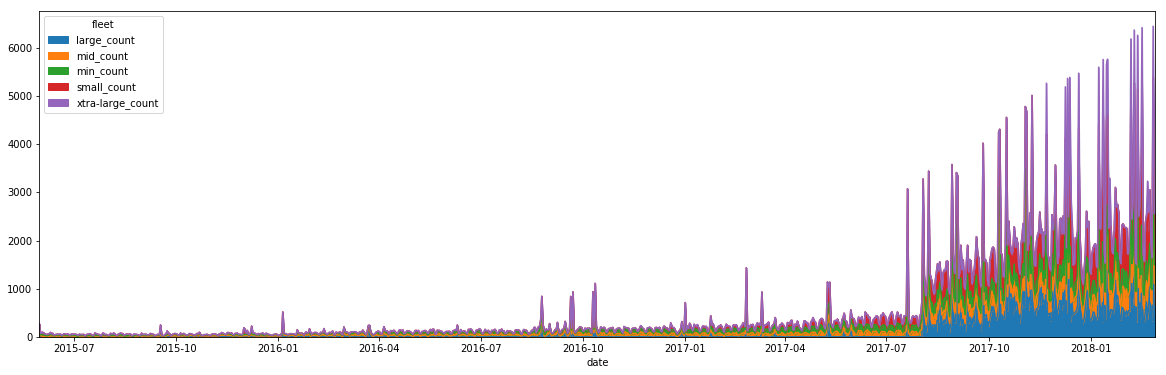

In [136]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 20
fig_size[1] = 6
plt.rcParams["figure.figsize"] =  fig_size 

# plot
plt.figure(figsize=(20,10))
fleet_seggregated_unstack.plot.area().get_figure().savefig('stacked-chart.png')